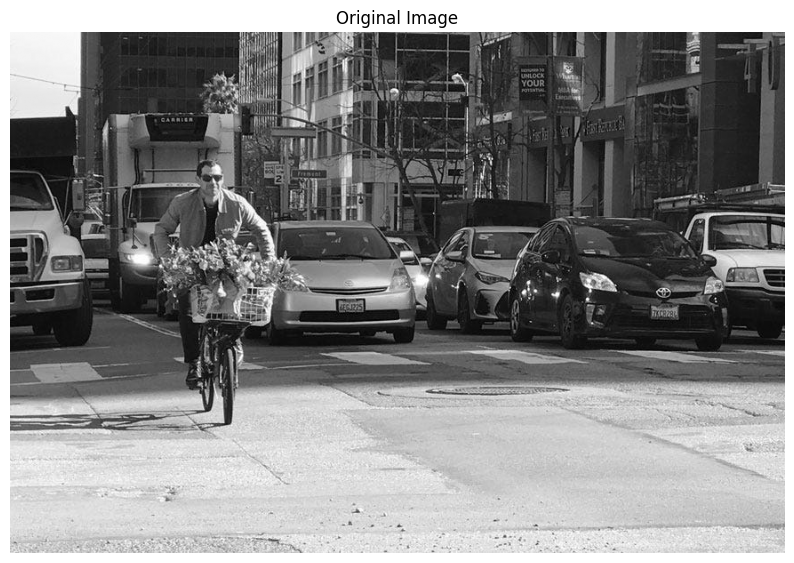

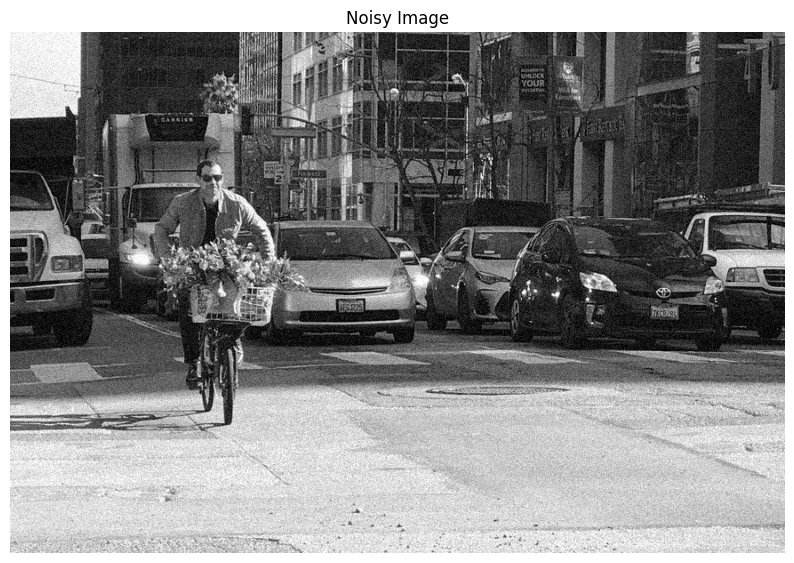

In [104]:
# Adaptive Manifold Filtering Tutorial

import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

img = cv2.imread("/home/alejandro/Pictures/bike.jpg", cv2.IMREAD_GRAYSCALE)
img = np.float32(img) / 255.0 

# Añadir diferentes tipos de ruido
# Gaussiano
mean, stddev = 0, 0.05
noise = np.random.normal(mean, stddev, img.shape)
noisy_img = np.clip(img + noise, 0, 1)
# Impulsional
# prob = 0.02  # Probabilidad de ruido
# rnd = np.random.rand(*img.shape)
# noisy_img[rnd < prob] = 0 # Sal (negro)
# noisy_img[rnd > 1 - prob] = 1 # Pimienta (blanco)
# Poisson
# noisy_img = np.random.poisson(noisy_img * 255) / 255.0  # Escalado correcto

plt.figure(figsize=(10, 8))
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(noisy_img, cmap="gray")
plt.title("Noisy Image")
plt.axis("off")
plt.show()

In [105]:
# Definir parámetros del filtro
sigma_s = 5.0 # Suavizado espacial
sigma_c = 0.1 # Suavizado en el dominio de intensidad/color

# Custom blur
def blur(a):
    return cv2.GaussianBlur(a, (-1, -1), sigma_s)

# Función para dividir la imagen en máscaras adaptativas
def am_split(img, mask):
    img_blur = blur(img * mask)
    mask_blur = blur(mask)
    m = cv2.divide(img_blur, mask_blur) # Media ponderada adaptativa
    lo_mask = np.float32(img <= m) * mask
    hi_mask = (1.0 - lo_mask) * mask
    return m, lo_mask, hi_mask

# Proyección de la imagen en la variedad adaptativa
def am_project(img, m):
    w = np.exp(-((img - m) ** 2) / (sigma_c ** 2)) # Peso basado en diferencias de intensidad
    bw, bwimg = blur(w), blur(w * img)
    return np.float32([bwimg * w, bw * w])

# Aplicación recursiva del filtro Adaptive Manifold
def am_filter(img, mask, depth):
    m, lo_mask, hi_mask = am_split(img, mask)
    wimg_w = am_project(img, m)
    if depth > 1:
        wimg_w += am_filter(img, lo_mask, depth - 1)
        wimg_w += am_filter(img, hi_mask, depth - 1)
    return wimg_w

def calculate_PSNR(img1, img2):
    '''Calcular la relación pico a ruido (PSNR)'''
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    maxVal = max(np.max(img1), np.max(img2))
    psnr = 20 * np.log10(maxVal) - 10 * np.log10(mse)
    return psnr

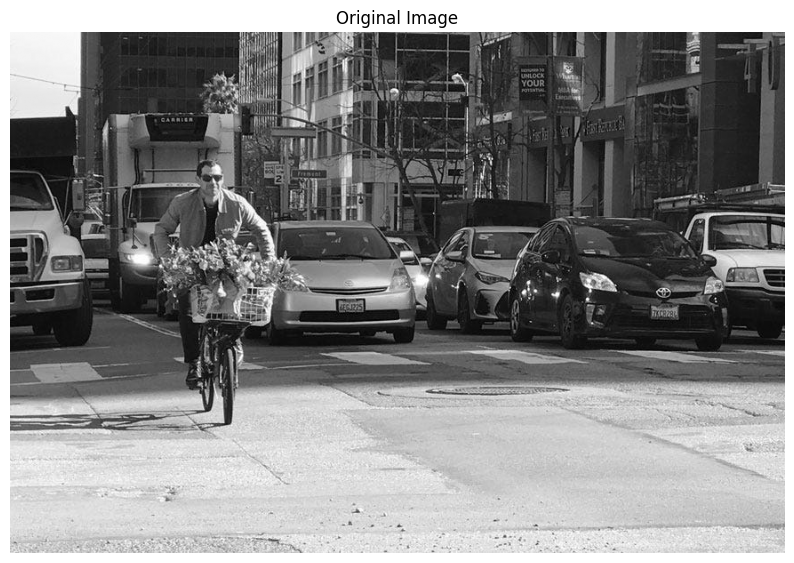

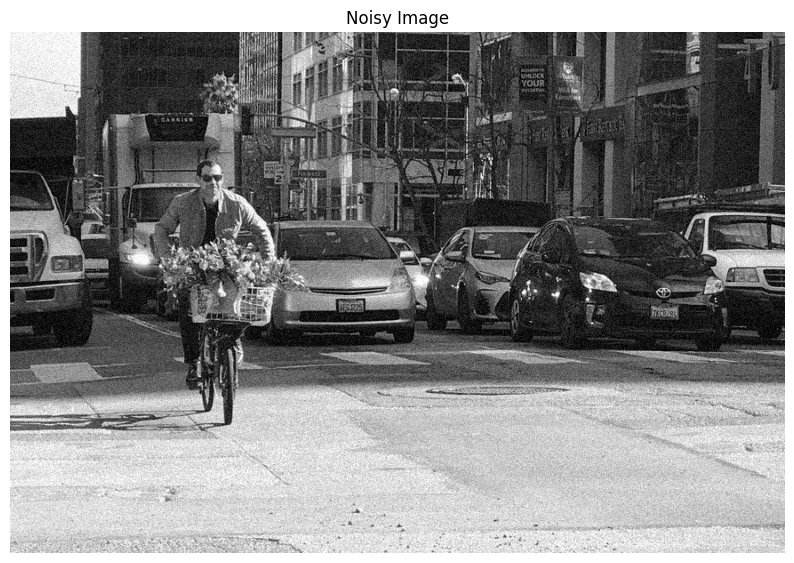

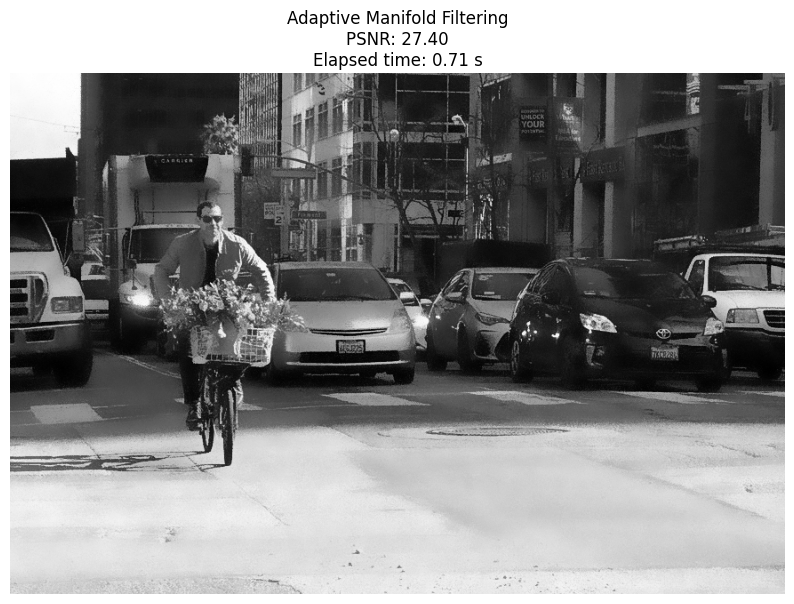

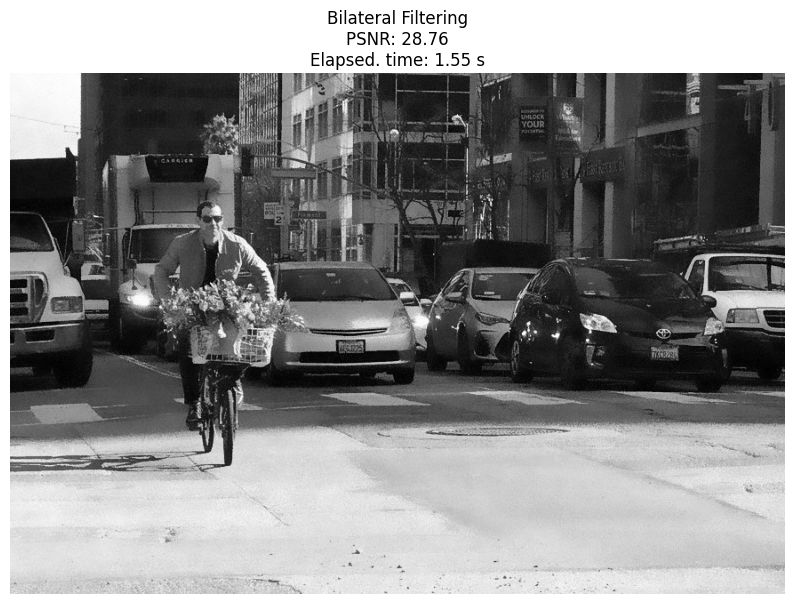

Tiempo de ejecución Adaptive Manifold: 0.7083 segundos
Tiempo de ejecución Filtro Bilateral: 1.5493 segundos
PSNR de Adaptive Manifold: 27.40
PSNR de Filtro Bilateral: 28.76


In [106]:
# Medir tiempo de ejecución del filtro Adaptive Manifold
start_time = time.time()
wimg, w = am_filter(noisy_img, np.ones_like(noisy_img), depth=4)
adaptive_manifold_result = wimg / w # Imagen filtrada
am_time = time.time() - start_time # Tiempo de ejecución

# Medir tiempo de ejecución del filtro Bilateral
start_time = time.time()
bilateral_filtered = cv2.bilateralFilter(noisy_img.astype(np.float32), 55, sigma_c, sigma_s)
bilateral_time = time.time() - start_time  # Tiempo de ejecución

# Calcular PSNR para ambos filtros
psnr_am = calculate_PSNR(img, adaptive_manifold_result)
psnr_bilateral = calculate_PSNR(img, bilateral_filtered)

# Mostrar resultados
plt.figure(figsize=(10, 8))
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(noisy_img, cmap="gray")
plt.title("Noisy Image")
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(adaptive_manifold_result, cmap="gray")
plt.title(f"Adaptive Manifold Filtering\nPSNR: {psnr_am:.2f}\nElapsed time: {am_time:.2f} s")
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(bilateral_filtered, cmap="gray")
plt.title(f"Bilateral Filtering\nPSNR: {psnr_bilateral:.2f}\nElapsed. time: {bilateral_time:.2f} s")
plt.axis("off")
plt.show()

# Imprimir tiempos de ejecución y PSNR
print(f"Tiempo de ejecución Adaptive Manifold: {am_time:.4f} segundos")
print(f"Tiempo de ejecución Filtro Bilateral: {bilateral_time:.4f} segundos")
print(f"PSNR de Adaptive Manifold: {psnr_am:.2f}")
print(f"PSNR de Filtro Bilateral: {psnr_bilateral:.2f}")